# BC4 

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc4


## Initial Setup

### Imports

In [42]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections
#import ta

warnings.filterwarnings('ignore')



In [43]:
from matplotlib.colors import LinearSegmentedColormap


In [44]:
from functools import reduce

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import SCORERS


In [46]:
#from pandas_datareader import data as pdr
#import yfinance as yf
#yf.pdr_override()


### Variables

In [47]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = '../imgs/'
DATA_IN_PATH = '../../source/data/'
DATA_OUT_PATH = '../../data_out/'


In [48]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [49]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

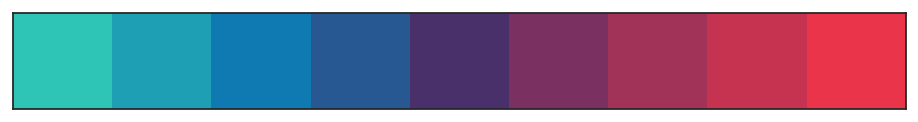

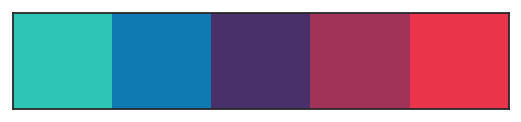

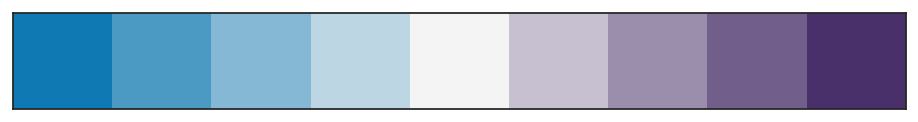

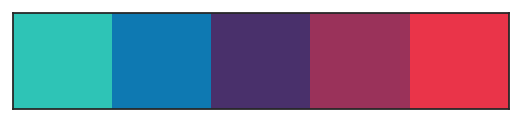

In [50]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load Data

In [51]:
df_all = pd.read_csv(DATA_OUT_PATH + "merged_data.csv")
df_all.head(3)

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,luna1_trend_macd,luna1_volatility_atr,matic_volume_obv,matic_momentum_rsi,matic_trend_macd,matic_volatility_atr,sol_volume_obv,sol_momentum_rsi,sol_trend_macd,sol_volatility_atr
0,2021-01-01,0.175350,0.184246,0.172022,0.181382,1.122218e+09,5.868556,6.506998,5.652401,6.490297,...,0.053993,0.051369,2.036519e+09,47.984858,-0.000144,0.001536,255658268.0,57.385950,-0.050738,0.191277
1,2021-01-02,0.177423,0.184253,0.169233,0.175359,1.408850e+09,5.414613,5.882211,5.319140,5.869282,...,0.053286,0.049277,2.053894e+09,53.344082,-0.000058,0.001609,223987204.0,55.832142,-0.027803,0.198930
2,2021-01-03,0.204995,0.208679,0.173376,0.177382,2.303858e+09,5.813898,5.900645,5.301713,5.416301,...,0.054555,0.049605,2.071803e+09,56.959753,0.000084,0.001614,279060626.0,64.577875,0.019398,0.235608


In [52]:
df_all = df_all.iloc[365:]

In [53]:
## How much data to use for model selection crossval
TRAIN_SIZE = 90

## How large the timeseriessplit window should be
WINDOW_SIZE = 7

## How many days for cv test
TEST_SIZE = 1

In [54]:
#df_all

In [55]:
def shift_split_data(df_, target_col, trainsize):
    df = df_.copy()
    df['Date_Y'] = df['Date'].shift(periods=-1)
    df['Y'] = df[target_col].shift(periods=-1)
    df.rename(columns={'Date':'Date_X'}, inplace=True)
    
    ## DF for prediction (only last trainsize days)
    ## Use to predict day after last df Date
    df_forprediction = df.iloc[trainsize:]
    
    ## DF for train + test (without last trainsize days)
    df_tt = df.iloc[:trainsize]
    return df_tt, df_forprediction
    
    

In [56]:
target_col = 'btc_close'

In [57]:
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

In [58]:
#df_tt

In [59]:
#df_forprediction

## Model Selection

In [60]:
#df_tt.head(5)

### Set up pipeline

In [61]:
score_func = 'neg_mean_absolute_percentage_error'

In [62]:
## Split X and Y

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

In [63]:
from sklearn.neural_network import MLPRegressor

In [64]:
model = MLPRegressor(random_state=RANDOM_STATE)

In [65]:
pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    model)

## Change params as needed
params_dt = {
    'selectkbest__k':[10,20,50],
    'mlpregressor__activation':['identity', 'logistic', 'tanh', 'relu'],
    'mlpregressor__solver': ['lbfgs'],
    'mlpregressor__max_fun': [10, 100, 1000]
    
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )



In [66]:
# Fit GS to training data
gs_dtr.fit(X, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=7, n_splits=11, test_size=1),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001B73E085550>)),
                                       ('mlpregressor',
                                        MLPRegressor(random_state=9))]),
             n_jobs=-1,
             param_grid={'mlpregressor__activation': ['identity', 'logistic',
                                                      'tanh', 'relu'],
                         'mlpregressor__max_fun': [10, 100, 1000],
                         'mlpregressor__solver': ['lbfgs'],
                         'selectkbest__k': [10, 20, 50]},
             scoring='neg_mean_absolute_percentage_error')

In [67]:
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores


,mean_test_score,params,rank_test_score
17,-0.029123,"{'mlpregressor__activation': 'logistic', 'mlpr...",1
12,-0.030875,"{'mlpregressor__activation': 'logistic', 'mlpr...",2
14,-0.032012,"{'mlpregressor__activation': 'logistic', 'mlpr...",3
11,-0.033883,"{'mlpregressor__activation': 'logistic', 'mlpr...",4
15,-0.034373,"{'mlpregressor__activation': 'logistic', 'mlpr...",5
16,-0.040271,"{'mlpregressor__activation': 'logistic', 'mlpr...",6
7,-0.040879,"{'mlpregressor__activation': 'identity', 'mlpr...",7
4,-0.040895,"{'mlpregressor__activation': 'identity', 'mlpr...",8
8,-0.043093,"{'mlpregressor__activation': 'identity', 'mlpr...",9
13,-0.043114,"{'mlpregressor__activation': 'logistic', 'mlpr...",10


In [68]:
gs_dtr.best_params_

{'mlpregressor__activation': 'logistic',
 'mlpregressor__max_fun': 1000,
 'mlpregressor__solver': 'lbfgs',
 'selectkbest__k': 50}

In [69]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=50,
                             score_func=<function f_regression at 0x000001B73E085550>)),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', max_fun=1000,
                              random_state=9, solver='lbfgs'))])

In [70]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([40684.84948666])